# Permutation Method for Correlation Hypothesis Test

In [1]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

For the permutation test, the hypothesized population correlation coefficient is assumed to be zero and sampling is done WITHOUT replacement. 

Each sample pair now consists of all the elements in x in their original order together with the elements in y in random order. 

In [2]:
import itertools
from math import factorial

In [3]:
p3 = pd.Series(itertools.permutations([1,2,3]))
print(p3)
print('Number of permutations = %i' %p3.shape[0])

0    (1, 2, 3)
1    (1, 3, 2)
2    (2, 1, 3)
3    (2, 3, 1)
4    (3, 1, 2)
5    (3, 2, 1)
dtype: object
Number of permutations = 6


For an array of size 3, the number of permutation without repetition is:

In [4]:
factorial(3)

6

What happens when the size is bigger?

In [5]:
factorial(6)

720

In [6]:
factorial(10)

3628800

In [7]:
factorial(50)

30414093201713378043612608166064768844377641568960512000000000000

It is impossible to compute all possible permutations, even for sample sizes not so large, like 50.

We will use the function `np.random.choice` to compute random permutations without repetitions, using the option `replace=False`

## The Data

In [8]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
grade_after2 = np.random.normal(90,   3, 80)

## Computing the correlation

In [9]:
np.corrcoef(grade_before, grade_after)[0][1]

0.0714339948718494

In [10]:
# Our statistic is the correlation coefficient between the two sets of grades.
stat_r = np.corrcoef(grade_before, grade_after)[0][1]
stat_r

0.0714339948718494

## Calculating the Correlation Sample Distribution using Permutation Method

For the permutation test, the hypothesized population correlation coefficient is assumed to be zero and sampling is done WITHOUT replacement. 

Each sample pair now consists of all the elements in x in their original order together with the elements in y in random order. 

In [11]:
def permSampleDistribution(sample_before, sample_after, num_samples=10000):
    '''
    It returns a list with the correlation sample distribution.
    '''
    corrSD = np.full((num_samples), 0.)
    x = np.array(sample_before)
    y = np.array(sample_after)
    idx = np.array(range(len(sample_after)))
    for k in range(num_samples):
        index = np.random.choice(idx, replace=False, size=len(idx))
        corrSD[k] = np.corrcoef(x, y[index])[0][1]
    return(corrSD)  

In [12]:
r_sample_distribution = permSampleDistribution(grade_before, grade_after)

In [13]:
def plotSampleDistribution(sample_distribution):
    '''
    It plots the sample distribution
    '''
    sns.kdeplot(sample_distribution, fill=True, color='orangered').set(title='Sample Distribution')

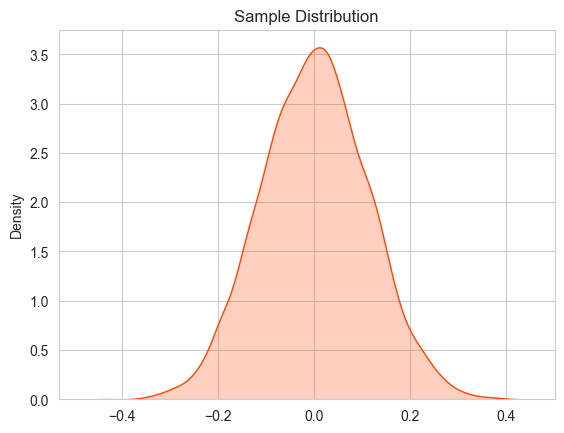

In [14]:
plotSampleDistribution(r_sample_distribution)

### Calculating the p-value

In [15]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):
    '''
    sample_distribution: the sample distribution
    obs_value: observed value 
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2 * min(ecdf(obs_value), 1-ecdf(obs_value))    
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [16]:
def hyp_test_corr(sample_distribution, sampl_value, alpha=0.05):
    '''
    It calculates the permutation hypothesis test for correlation.
    sampl_value: statistic calculated from the sample
    sampl_distribution: sample distribution calculated using bootstrap from the sample
    alpha: significance level
    '''
    print('--- Correlation Hypothesis Test using Permutation Method ---')
    print('    Ho: r == 0')
    print('    Ha: r != 0')
    # computing the sample distribution under Ho
    #sample_distribution_Ho = sample_distribution - np.mean(sample_distribution)
    sample_distribution_Ho = sample_distribution
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True, alpha=0.4)
    plt.title('Permutation Sampling Distribution')
    # plotting the statistic
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    # calculating the p-value
    p_val = getpValue(sample_distribution_Ho, sampl_value)
    # plotting the critical regions
    cv1 = np.round(np.percentile(sample_distribution_Ho, (alpha/2)*100),2)       # left critical value  
    cv2 = np.round(np.percentile(sample_distribution_Ho, 100-(alpha/2)*100),2)   # right critical value  
    plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    r = %.4f    p-value = %.4f' %(sampl_value, p_val))

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714    p-value = 0.5224


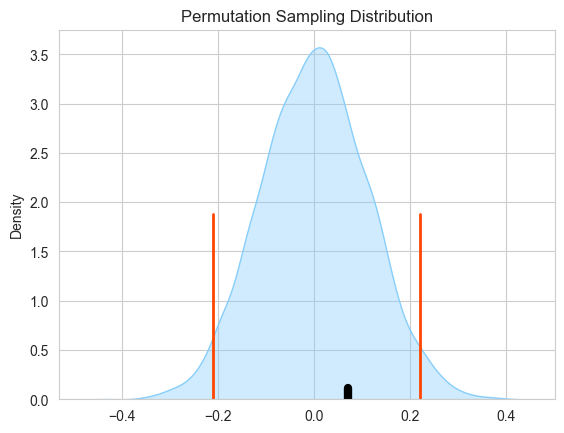

In [17]:
hyp_test_corr(r_sample_distribution, stat_r)

p-value > 0.05 We have no reason to reject the null hypothesis!

There is no correlation between the two variables: `grade_before` and `grade_after`

### Summarizing

In [18]:
class permCorr():
    '''
    It calculates the correlation hypothesis test using permutation method.
    '''

    def __init__(self, sample1, sample2, num_samples=10000):
        '''
        '''
        # The correlation value between sample1 and sample2
        self.stat_r = np.corrcoef(sample1,sample2)[0][1]
        # Calculating the bootstrap sample distribution
        self.r_sample_distribution = permSampleDistribution(sample1, sample2, num_samples=num_samples)
        

    def permSampleDistribution(self, sample_before, sample_after, num_samples=10000):
        '''
        It returns a list with the correlation sample distribution.
        '''
        corrSD = np.full((num_samples), 0.)
        x = np.array(sample_before)
        y = np.array(sample_after)
        idx = np.array(range(len(sample_after)))
        for k in range(num_samples):
            index = np.random.choice(idx, replace=False, size=len(idx))
            corrSD[k] = np.corrcoef(x, y[index])[0][1]
        return(corrSD) 


    def getpValue(self, sample_distribution, obs_value, alternative='two-sided'):
        '''
        It returns the p-value.
        sample_distribution: the sample distribution
        obs_value:           observed value 
        alpha:               significance level
        alternative:         one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        ecdf = ECDF(sample_distribution) 
        if alternative=='two-sided':
            p_val = 2 * min(ecdf(obs_value), 1-ecdf(obs_value))
        elif alternative=='smaller':
            p_val = ecdf(obs_value)
        else:
            p_val = 1-ecdf(obs_value)
        return(p_val)    


    def hyp_test_corr(self, alpha=0.05):
        '''
        It calculates the correlation coefficient's bootstrap hypothesis test.
        sampl_value:        statistic calculated from the sample
        sampl_distribution: sample distribution calculated using bootstrap from the sample
        alpha:              significance level
        '''
        print('--- Correlation Hypothesis Test using Permutation Method ---')
        print('    Ho: r == 0')
        print('    Ha: r != 0')
        # computing the sample distribution under Ho
        #sample_distribution_Ho = self.r_sample_distribution - np.mean(self.r_sample_distribution)
        sample_distribution_Ho = self.r_sample_distribution
        # plotting the sample distribution
        sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', fill=True, alpha=0.4)
        plt.title('Bootstrap Sampling Distribution')
        # plotting the statistic
        plt.axvline(x=self.stat_r, ymin=0, ymax= 0.03, color='black', linewidth=6)
        # calculating the p-value
        p_val = getpValue(sample_distribution_Ho, self.stat_r)
        # plotting the critical regions
        cv1 = np.round(np.percentile(sample_distribution_Ho, (alpha/2)*100),2)       # left critical value  
        cv2 = np.round(np.percentile(sample_distribution_Ho, 100-(alpha/2)*100),2)   # right critical value  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        print('    r = %.4f    p-value = %.4f' %(self.stat_r, p_val))


    def corr(self, alpha=0.05):
        '''
        It allows you to calculate one of the the correlation hypothesis tests using permutation method 
        '''    
        self.hyp_test_corr(alpha=alpha)
        

In [19]:
P = permCorr(grade_before, grade_after)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714    p-value = 0.5198


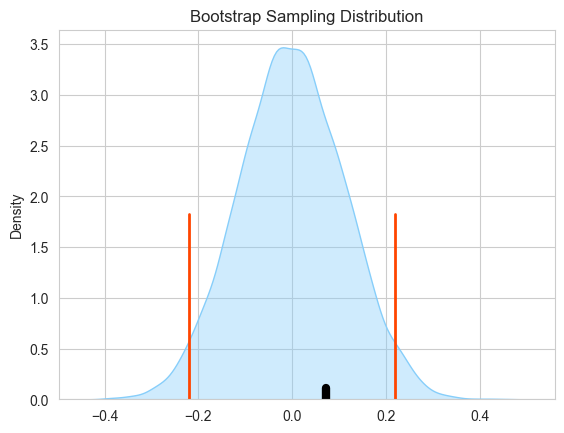

In [20]:
P.corr()

In [21]:
P2 = permCorr(grade_before, grade_after2)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = 0.1077    p-value = 0.3266


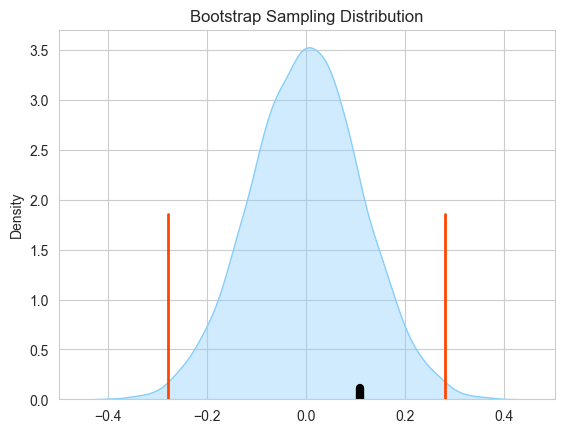

In [22]:
P2.corr(alpha=0.01)

There is not reason for rejecting Ho, the correlation is not significant!

## Examples

In [23]:
df = pd.read_csv('corrExamples.csv')
print(df.shape)
df.head(3)

(50, 6)


,x,y_spc,y_snc,y_wpc,y_wnc,y_nc
0,14.946016,60.934277,-18.311426,15.939970,-5.939970,7.075053
1,12.280831,52.439626,-15.479875,21.534672,-11.534672,9.034883
2,12.554739,52.487695,-15.495898,20.719120,-10.719120,3.187492


### Strong Correlation

In [24]:
Ps1 = permCorr(df.x, df.y_spc)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9734    p-value = 0.0000


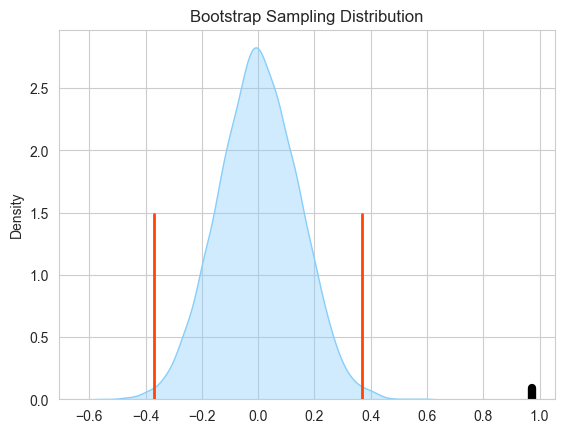

In [25]:
Ps1.corr(alpha=0.01)

In [26]:
Ps2 = permCorr(df.x, df.y_snc)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9734    p-value = 0.0000


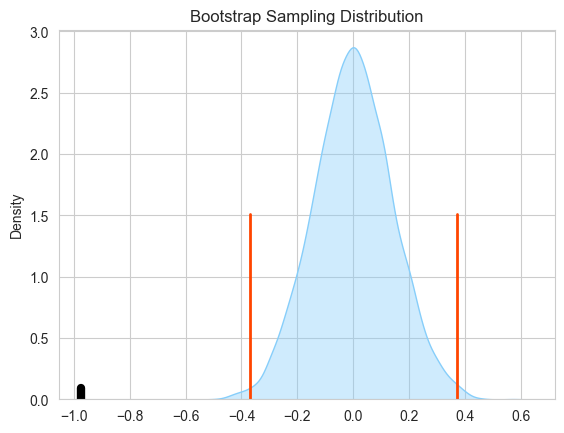

In [27]:
Ps2.corr(alpha=0.01)

### Weak Correlation

In [28]:
Ps3 = permCorr(df.x, df.y_wpc)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = 0.2898    p-value = 0.0432


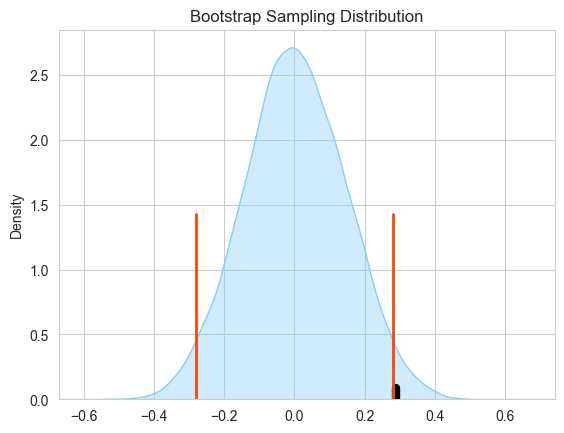

In [29]:
Ps3.corr(alpha=0.05)

In [30]:
Ps4 = permCorr(df.x, df.y_wnc)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = -0.2898    p-value = 0.0426


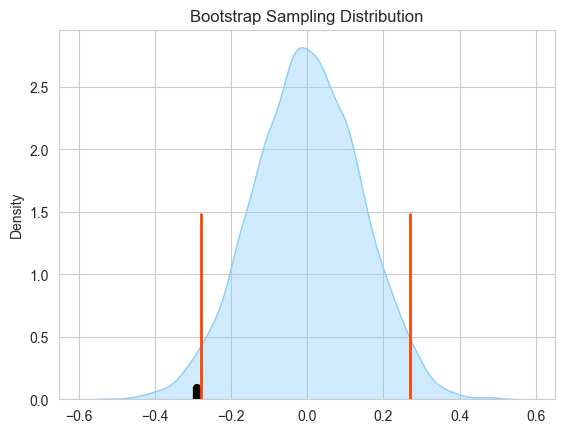

In [31]:
Ps4.corr(0.05)

In [32]:
Ps5 = permCorr(df.x, df.y_nc)

--- Correlation Hypothesis Test using Permutation Method ---
    Ho: r == 0
    Ha: r != 0
    r = -0.1384    p-value = 0.3268


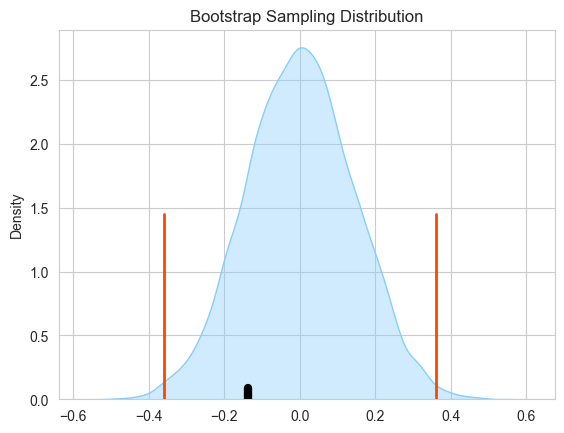

In [33]:
Ps5.corr(0.01)

## References

- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.